In [4]:
import math, random, os

import sys
sys.path.append('..')


import numpy as np
import pandas as pd
from collections import defaultdict

import os
import torch
import torch.nn as nn
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [5]:
######################################## load data from junyi log
bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/junyi/'

# exercise 837, topic 41, area 9
# exercise = pd.read_csv(bath_path+'junyi_Exercise_table.csv', encoding = "utf-8",low_memory=False) 
# relation = pd.read_csv(bath_path+'relationship_annotation_training.csv', encoding = "utf-8",low_memory=False)
log = pd.read_csv(bath_path+'junyi_ProblemLog_original.csv', encoding = "utf-8",low_memory=False)

users = log.groupby(['user_id', 'exercise']).size().reset_index(name='count')
users[users['count']>100]
# users = users.sort_values('count')

,user_id,exercise,count
98,16,adding_and_subtracting_negative_numbers,118
387,52,alternate_exterior_angles,119
388,52,alternate_interior_angles,101
492,52,metric_weight_unit_conversion,136
654,64,reading_fractions_in_chinese,148
...,...,...,...
2288785,247492,multiplication_0.5,741
2288786,247492,multiplication_1,266
2288888,247507,subtraction_1,113
2289046,247529,addition_1,119


In [3]:
################### find specific data
user201 = log.loc[(log.user_id == 247569) & (log.exercise == 'divisibility_0.5')]
user118 = log.loc[(log.user_id == 16) & (log.exercise == 'adding_and_subtracting_negative_numbers')]
user384 = log.loc[(log.user_id == 945) & (log.exercise == 'number_line_3')]

user118 = user118.sort_values('time_done')
user201 = user201.sort_values('time_done')
user384 = user384.sort_values('time_done')

# first = log.loc[(log.user_id == 88703) & (log.exercise == 'telling_time_comparing')]
# second = log.loc[(log.user_id == 88703) & (log.exercise == 'time_units_transformation_1')]
# third = log.loc[(log.user_id == 52504) & (log.exercise == 'radical_equations')]
# first = first.sort_values('time_done')

user118.to_csv('user118.csv', sep='\t')
user201.to_csv('user201.csv', sep='\t')
user384.to_csv('user384.csv', sep='\t')

In [ ]:
######################################## load data from pre-defined user-specific log
user118 = pd.read_csv('user118.csv', sep='\t')

num_seq = 1
num_node = 1

t_data = torch.tensor(np.array(user118['time_done'].values), device=device).reshape(1, -1)
x_data = torch.tensor(np.array(user118['correct'].values*1), device=device).reshape(1, -1)

In [3]:
################### rescale time data
log_t_data = [] # so that the log(diff(t_data)) = diff(log_t_data)
dt = torch.log(torch.diff(t_data))
log_t_data.append(torch.zeros_like(dt[:,0]))
for i in range(0, dt.shape[-1]):
    log_t_data.append(log_t_data[-1] + dt[:, i])
log_t_data = torch.stack(log_t_data, -1)

NameError: name 't_data' is not defined

In [61]:
######################################## single_user_single_exercise
useful_log = log[['user_id', 'exercise', 'time_done', 'correct']]
max_num = 200
interaction = pd.DataFrame(['user_id', 'skill', 'time_seq', 'correct_seq'])

users[users['count']>max_num]
users_with_threshold = users[users['count']>max_num]

single_user_single_exercise = dict({
    'user_id': [],
    'skill': [],
    'time_seq': [],
    'correct_seq': [],
})

sk_dfs = []
for i in range(len(users_with_threshold)):
    if i % 50==0:
        print(i)
    id = users_with_threshold.user_id.iloc[i]
    ex = users_with_threshold.exercise.iloc[i]

    single_user_exercise = useful_log.loc[(useful_log.user_id == id) & (useful_log.exercise == ex)]
    single_user_exercise = single_user_exercise.sort_values('time_done')[:max_num]

    sk_dfs.append(single_user_exercise)
    
# single_user_single_exercise = pd.DataFrame.from_dict(single_user_single_exercise)
# single_user_single_exercise.to_csv('single_user_single_exercise_junyi_200.csv')

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650


In [ ]:
######################################## exercise-id re-match
# same as preprocessing
exercise = pd.read_csv(bath_path+'junyi_Exercise_table.csv', encoding = "utf-8",low_memory=False) 
num_ex = len(exercise)

ex_new_id = pd.DataFrame(columns=['exercise_name', 'exercise_id', 'prerequisite_name', 'prerequisite_id'])
ex_new_id['exercise_name'] = exercise.name
ex_new_id['exercise_id'] = np.arange(len(exercise))
ex_new_id['prerequisite_name'] = exercise.prerequisites

for i in range(len(ex_new_id.prerequisite_name)):
    pre = ex_new_id['prerequisite_name'][i]
    ind = exercise.loc[exercise.name == pre].index
    if len(ind) == 0:
        ex_new_id.prerequisite_id[i] = np.nan
    else:
        ex_new_id.prerequisite_id[i] = ind[0]

In [72]:
import pickle
pickle.dump(sk_dfs, open('sk_dfs.pkl', 'wb'))

In [64]:
test = sk_dfs
test = pd.concat(test, axis=0)
test.columns = ['original_user_id', 'skill_name', 'timestamp', 'correct']

new_id = [[i] * max_num for i in range(len(sk_dfs))]
new_user_id = [item for sublist in new_id for item in sublist]
test['user_id'] = new_user_id

skill_dict = dict(zip(ex_new_id.exercise_name, ex_new_id.exercise_id))
test['skill_id'] = test['skill_name'].apply(lambda x: skill_dict[x])

test['problem_id'] = test.skill_id

test = test.astype({
    'timestamp': np.float64,
    # 'dwell_time': np.float64,
    'correct': np.float64,
    'problem_id': np.int64,
    'skill_id': np.int64,
    'user_id': np.int64,
    })

# Save
bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/junyi/single_user_single_skill/'
test.to_csv(bath_path+'interactions_{}.csv'.format(max_num), sep='\t', index=False)

In [148]:
######################################## add statistics
num_seq = 1
num_node = 1
def add_statistics(x_data, time_step):
    num_total = np.arange(time_step) # how many times in total has the learner tried
    success = 0
    num_success = []
    for i in range(time_step):
        if x_data[i] == 1:
            success += 1
        num_success.append(success)
    num_failure = num_total-num_success

    stats = np.stack([num_total, num_success, num_failure], -1).reshape(num_seq, num_node, -1, 3)
    # stats = torch.tensor(stats, device=device)
    return stats

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import default_collate

class CustomImageDataset(Dataset):
    def __init__(self, single_user_single_exercise, device):
        self.pd_data = single_user_single_exercise
        self.device = device
        
    def __len__(self):
        return len(self.pd_data)
    
    def __getitem__(self, idx):
        user_id = self.pd_data.user_id.iloc[idx]
        time_seq = [int(s) for s in self.pd_data.time_seq.iloc[idx][1:-1].split(',')] 
        time_seq = np.array(time_seq)
        correct_seq = [int(s) for s in self.pd_data.correct_seq.iloc[idx][1:-1].split(',')] 
        correct_seq = np.array(correct_seq)
        stats = add_statistics(correct_seq, len(correct_seq))[0]
        return user_id, time_seq, correct_seq, stats

In [149]:
dataset = CustomImageDataset(single_user_single_exercise, device)
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler,
                                          collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler,
                                            collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))

In [160]:
model = HLR(mode='train', device=device)
num_epochs = 10
learning_rate = 1e-3 
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Train:   
    for _, (user_id, time_seq, correct_seq, stats) in enumerate(train_loader):
        # user_id [bs]
        # time_seq [bs, max_time]
        # correct_seq [bs, max_time]
        # stats [bs, 1, 1, max_time, 3]
        x0 = correct_seq[:, :1]
        x_gt = correct_seq[:, 1:]
        x_pred, params = model.simulate_path(x0=x0, t=time_seq, stats=stats)
        p = params['x_item_pred']
        h = params['half_life']
        bceloss = loss_fn(p, x_gt.float())

        optimizer.zero_grad()
        bceloss.backward()
        optimizer.step()
    
        print('x_pred: ', x_pred)
        print('loss: ', bceloss)
        print('previous theta: ', model.theta.clone())

x_pred:  tensor([[[1.0000, 0.5000, 0.5000,  ..., 0.7165, 0.7167, 0.7130]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7179, 0.7141, 0.7176]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        ...,

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.7050, 0.6996, 0.7064]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],
       device='cuda:0', grad_fn=<StackBackward0>)
loss:  tensor(0.6183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
previous theta:  tensor([-1.0296,  1.1021, -0.8681], device='cuda:0', grad_fn=<CloneBackward0>)
x_pred:  tensor([[[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        ...,

        [[1.0000, 0.5000, 0.5026,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.50

x_pred:  tensor([[[0.0000, 0.5000, 0.5000,  ..., 0.7067, 0.6732, 0.5749]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5178, 0.5136]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7184, 0.7007, 0.6725]],

        ...,

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5011, 0.5016,  ..., 0.7180, 0.7171, 0.7167]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7073, 0.7077, 0.7053]]],
       device='cuda:0', grad_fn=<StackBackward0>)
loss:  tensor(0.6268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
previous theta:  tensor([-1.0131,  1.1183, -0.8678], device='cuda:0', grad_fn=<CloneBackward0>)
x_pred:  tensor([[[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7065, 0.7118, 0.7154]],

        ...,

        [[1.0000, 0.5002, 0.5038,  ..., 0.7198, 0.7195, 0.7190]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.7157, 0.7194, 0.71

x_pred:  tensor([[[1.0000, 0.5000, 0.5004,  ..., 0.6801, 0.7212, 0.7201]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5576, 0.5351, 0.6269]],

        ...,

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5023, 0.5000,  ..., 0.6784, 0.7105, 0.7078]],

        [[1.0000, 0.5000, 0.5005,  ..., 0.7192, 0.7170, 0.7177]]],
       device='cuda:0', grad_fn=<StackBackward0>)
loss:  tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
previous theta:  tensor([-1.0020,  1.1291, -0.8675], device='cuda:0', grad_fn=<CloneBackward0>)
x_pred:  tensor([[[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.6946, 0.6863, 0.6961]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        ...,

        [[1.0000, 0.5000, 0.5000,  ..., 0.7159, 0.7189, 0.7071]],

        [[1.0000, 0.5004, 0.5020,  ..., 0.7191, 0.7198, 0.71

x_pred:  tensor([[[1.0000, 0.5004, 0.5008,  ..., 0.7053, 0.7131, 0.7148]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5145, 0.5001, 0.5607]],

        ...,

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]]],
       device='cuda:0', grad_fn=<StackBackward0>)
loss:  tensor(0.5798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
previous theta:  tensor([-0.9938,  1.1371, -0.8673], device='cuda:0', grad_fn=<CloneBackward0>)
x_pred:  tensor([[[0.0000, 0.5000, 0.5000,  ..., 0.7062, 0.7070, 0.6945]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.7170, 0.6568, 0.7186]],

        [[1.0000, 0.5000, 0.5010,  ..., 0.7177, 0.7177, 0.7163]],

        ...,

        [[1.0000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

        [[0.0000, 0.5000, 0.5000,  ..., 0.7073, 0.7054, 0.70

KeyboardInterrupt: 

In [166]:
from models.parametric_models import VanillaOU
model = VanillaOU(mode='train',device=device)
num_epochs = 10
learning_rate = 1e-3 
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Train:   
    for _, (user_id, time_seq, correct_seq, stats) in enumerate(train_loader):
        # user_id [bs]
        # time_seq [bs, max_time]
        # correct_seq [bs, max_time]
        # stats [bs, 1, 1, max_time, 3]
        x0 = correct_seq[:, :1]
        x_gt = correct_seq[:, 1:]
        x_pred, params = model.simulate_path(x0=x0, t=time_seq)
        x_pred = torch.sigmoid(x_pred)
        
        bceloss = loss_fn(x_pred[:,0,1:].float(), x_gt.float())
        optimizer.zero_grad()
        bceloss.backward(retain_graph=True)
        optimizer.step()
        
        for p in model.parameters():
            p.data.clamp_(0)
            
        print('x_pred: ', x_pred)
        print('loss: ', bceloss)

x_pred:  tensor([[[0.7311, 0.6385, 0.5974,  ..., 0.4350, 0.6950, 0.5391]],

        [[0.7311, 0.7935, 0.7151,  ..., 0.4595, 0.9449, 0.6396]],

        [[0.7311, 0.8946, 0.6721,  ..., 0.5538, 0.9074, 0.6608]],

        ...,

        [[0.7311, 0.7103, 0.5756,  ..., 0.3547, 0.4922, 0.5517]],

        [[0.5000, 0.7668, 0.8117,  ..., 0.4915, 0.6373, 0.8568]],

        [[0.7311, 0.9461, 0.7216,  ..., 0.7096, 0.2301, 0.7017]]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SigmoidBackward0>)
loss:  tensor(0.5445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
x_pred:  tensor([[[0.7311, 0.7508, 0.8143,  ..., 0.5385, 0.9110, 0.9036]],

        [[0.5000, 0.3746, 0.7781,  ..., 0.6130, 0.7569, 0.4594]],

        [[0.7311, 0.6003, 0.6425,  ..., 0.5447, 0.8033, 0.8700]],

        ...,

        [[0.7311, 0.6687, 0.8518,  ..., 0.8261, 0.3956, 0.3042]],

        [[0.7311, 0.7080, 0.5237,  ..., 0.7981, 0.9350, 0.6160]],

        [[0.7311, 0.7191, 0.6858,  ..., 0.7200, 0.7605, 0.8926]]],

x_pred:  tensor([[[0.7311, 0.5578, 0.7435,  ..., 0.6463, 0.8666, 0.5800]],

        [[0.7311, 0.8379, 0.5343,  ..., 0.3867, 0.7476, 0.7107]],

        [[0.5000, 0.4837, 0.8352,  ..., 0.8449, 0.5854, 0.7562]],

        ...,

        [[0.5000, 0.5599, 0.5414,  ..., 0.6441, 0.8012, 0.6646]],

        [[0.5000, 0.6195, 0.8446,  ..., 0.8213, 0.9170, 0.5227]],

        [[0.5000, 0.8768, 0.5241,  ..., 0.5845, 0.8765, 0.9053]]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SigmoidBackward0>)
loss:  tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
x_pred:  tensor([[[0.7311, 0.8082, 0.6741,  ..., 0.7748, 0.3898, 0.7288]],

        [[0.7311, 0.4541, 0.3733,  ..., 0.6465, 0.6685, 0.4876]],

        [[0.7311, 0.8498, 0.7147,  ..., 0.5673, 0.5590, 0.6753]],

        ...,

        [[0.7311, 0.7527, 0.8672,  ..., 0.9037, 0.7834, 0.5733]],

        [[0.5000, 0.3583, 0.3236,  ..., 0.6546, 0.8231, 0.7193]],

        [[0.5000, 0.8122, 0.5673,  ..., 0.7122, 0.9330, 0.6054]]],

x_pred:  tensor([[[0.7311, 0.9338, 0.3848,  ..., 0.8423, 0.8388, 0.9267]],

        [[0.5000, 0.7367, 0.7772,  ..., 0.5574, 0.4793, 0.5348]],

        [[0.5000, 0.5316, 0.8446,  ..., 0.8520, 0.6895, 0.8422]],

        ...,

        [[0.7311, 0.7670, 0.8158,  ..., 0.7194, 0.6773, 0.7437]],

        [[0.7311, 0.8140, 0.8824,  ..., 0.7539, 0.4787, 0.5499]],

        [[0.5000, 0.5655, 0.7885,  ..., 0.4423, 0.2434, 0.5031]]],
       device='cuda:0', dtype=torch.float64, grad_fn=<SigmoidBackward0>)
loss:  tensor(0.5566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
x_pred:  tensor([[[0.5000, 0.7794, 0.8576,  ..., 0.5640, 0.6832, 0.6452]],

        [[0.7311, 0.4990, 0.7840,  ..., 0.8362, 0.7291, 0.6564]],

        [[0.7311, 0.5473, 0.6190,  ..., 0.6507, 0.8157, 0.7351]],

        ...,

        [[0.7311, 0.7383, 0.9093,  ..., 0.6093, 0.8905, 0.8915]],

        [[0.7311, 0.4496, 0.8370,  ..., 0.8159, 0.7906, 0.9133]],

        [[0.7311, 0.7658, 0.7829,  ..., 0.6986, 0.8517, 0.8246]]],

KeyboardInterrupt: 

In [194]:
################### rescale time data
log_t_data = [] # so that the log(diff(t_data)) = diff(log_t_data)
dt = torch.log(torch.diff(t_data))
log_t_data.append(torch.zeros_like(dt[:,0]))
for i in range(0, dt.shape[-1]):
    log_t_data.append(log_t_data[-1] + dt[:, i])
log_t_data = torch.stack(log_t_data, -1)

[(array([[1396074712950590, 1396074731829670, 1396074773575750, ...,
          1398852710575690, 1398852992033000, 1398852994450900],
         [1415262416498920, 1415262419445660, 1415262422195060, ...,
          1415263057357550, 1415263059526660, 1415263061520220],
         [1387787774940730, 1387787781184910, 1387787799123690, ...,
          1388048675490840, 1388048679178310, 1388048680993940],
         ...,
         [1415795063793670, 1415795070589590, 1415795076839730, ...,
          1419502373008050, 1419502377533750, 1419502384260280],
         [1413724796537240, 1413724806822940, 1413724814720990, ...,
          1415013021904710, 1415013029341670, 1415013036723360],
         [1392187490662380, 1392187502786280, 1392187529079100, ...,
          1398341836997900, 1398341839500620, 1398341841491520]]),
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [0, 0, 0, ..., 0, 0, 

In [212]:
# from ou_estimator import OrnsteinUhlenbeckEstimator
log_t_data = [] # so that the log(diff(t_data)) = diff(log_t_data)
dt = torch.log(torch.diff(t_data))
log_t_data.append(torch.zeros_like(dt[:,0]))
for i in range(0, dt.shape[-1]):
    log_t_data.append(log_t_data[-1] + dt[:, i])
log_t_data = torch.stack(log_t_data, -1)

numpy_data = [(time_seq.cpu().numpy(), correct_seq.cpu().numpy()) for _, (_, time_seq, correct_seq, _) in enumerate(train_loader)]
estimator = OrnsteinUhlenbeckEstimator(numpy_data, n_it=10)

In [213]:
print(f'mu = {estimator.mu}')
print(f'eta = {estimator.eta}')
print(f'sigma^2 = {estimator.sigma_sq()}')

mu = 0.8482042530182574
eta = 1.0496364139222869e-06
sigma^2 = 7.670892715022106e-10


In [218]:
modeltest = NologOU(mean_rev_speed=torch.tensor(1.0496364139222869e-06,device=device), 
                 mean_rev_level=torch.tensor(0.8482042530182574,device=device), 
                 vola=torch.sqrt(torch.tensor(7.670892715022106e-10,device=device)), mode='synthetic',device=device)

for _, (user_id, time_seq, correct_seq, stats) in enumerate(train_loader):
    # user_id [bs]
    # time_seq [bs, max_time]
    # correct_seq [bs, max_time]
    # stats [bs, 1, 1, max_time, 3]
    x0 = correct_seq[:, :1]
    x_gt = correct_seq[:, 1:]
    x_pred, params = modeltest.simulate_path(x0=x0, t=time_seq)
    x_pred = torch.sigmoid(x_pred)

    bceloss = loss_fn(x_pred[:,0,1:].float(), x_gt.float())
    # optimizer.zero_grad()
    # bceloss.backward(retain_graph=True)
    # optimizer.step()

    # for p in model.parameters():
    #     p.data.clamp_(0)

    print('x_pred: ', x_pred)
    print('loss: ', bceloss)

x_pred:  tensor([[[0.7311, 0.7005, 0.6999,  ..., 0.7054, 0.7035, 0.7008]],

        [[0.7311, 0.6998, 0.7010,  ..., 0.7025, 0.6974, 0.6971]],

        [[0.7311, 0.7030, 0.6979,  ..., 0.6967, 0.7042, 0.7036]],

        ...,

        [[0.7311, 0.6979, 0.7005,  ..., 0.7010, 0.6992, 0.6994]],

        [[0.7311, 0.7069, 0.7021,  ..., 0.7040, 0.7029, 0.6989]],

        [[0.5000, 0.7013, 0.6955,  ..., 0.7017, 0.6999, 0.6994]]],
       device='cuda:0')
loss:  tensor(0.4826, device='cuda:0')
x_pred:  tensor([[[0.7311, 0.7038, 0.7051,  ..., 0.6985, 0.6984, 0.6967]],

        [[0.7311, 0.7007, 0.6960,  ..., 0.6984, 0.6914, 0.7047]],

        [[0.7311, 0.6949, 0.6984,  ..., 0.7038, 0.6962, 0.7001]],

        ...,

        [[0.5000, 0.6976, 0.7017,  ..., 0.6930, 0.7010, 0.7008]],

        [[0.7311, 0.7022, 0.7039,  ..., 0.7013, 0.7045, 0.6977]],

        [[0.7311, 0.7046, 0.7007,  ..., 0.7034, 0.6980, 0.6964]]],
       device='cuda:0')
loss:  tensor(0.5595, device='cuda:0')
x_pred:  tensor([[[0.731

x_pred:  tensor([[[0.7311, 0.6951, 0.7011,  ..., 0.7017, 0.7045, 0.7022]],

        [[0.7311, 0.7050, 0.7014,  ..., 0.7020, 0.6954, 0.7042]],

        [[0.7311, 0.7007, 0.7041,  ..., 0.6930, 0.6985, 0.6997]],

        ...,

        [[0.7311, 0.6990, 0.6994,  ..., 0.6982, 0.6952, 0.7038]],

        [[0.7311, 0.7001, 0.7033,  ..., 0.7024, 0.7042, 0.7016]],

        [[0.5000, 0.7036, 0.7002,  ..., 0.7002, 0.7031, 0.6949]]],
       device='cuda:0')
loss:  tensor(0.4707, device='cuda:0')
x_pred:  tensor([[[0.7311, 0.6959, 0.7035,  ..., 0.6999, 0.6986, 0.7023]],

        [[0.7311, 0.6981, 0.6995,  ..., 0.6939, 0.6945, 0.6981]],

        [[0.7311, 0.6991, 0.6929,  ..., 0.7016, 0.7067, 0.6976]],

        ...,

        [[0.5000, 0.6983, 0.7013,  ..., 0.6976, 0.6975, 0.6991]],

        [[0.5000, 0.7006, 0.7018,  ..., 0.7037, 0.7030, 0.7037]],

        [[0.7311, 0.6998, 0.7052,  ..., 0.6968, 0.7013, 0.7026]]],
       device='cuda:0')
loss:  tensor(0.4947, device='cuda:0')
x_pred:  tensor([[[0.500

x_pred:  tensor([[[0.7311, 0.7007, 0.6979,  ..., 0.6987, 0.7007, 0.6989]],

        [[0.7311, 0.7022, 0.6917,  ..., 0.6952, 0.6982, 0.7011]],

        [[0.7311, 0.7010, 0.7029,  ..., 0.7011, 0.6971, 0.6981]],

        ...,

        [[0.7311, 0.7039, 0.6994,  ..., 0.6962, 0.7031, 0.6971]],

        [[0.7311, 0.7008, 0.7004,  ..., 0.7028, 0.7004, 0.6995]],

        [[0.7311, 0.7056, 0.6994,  ..., 0.7030, 0.6974, 0.6997]]],
       device='cuda:0')
loss:  tensor(0.4651, device='cuda:0')
x_pred:  tensor([[[0.7311, 0.7067, 0.7015,  ..., 0.7024, 0.6995, 0.6962]],

        [[0.5000, 0.6898, 0.6994,  ..., 0.7040, 0.6959, 0.7011]],

        [[0.7311, 0.7038, 0.7024,  ..., 0.7033, 0.7069, 0.7044]],

        ...,

        [[0.5000, 0.7007, 0.6975,  ..., 0.7053, 0.7015, 0.6981]],

        [[0.7311, 0.7000, 0.7020,  ..., 0.7039, 0.6991, 0.7034]],

        [[0.7311, 0.6974, 0.6991,  ..., 0.6997, 0.7025, 0.6999]]],
       device='cuda:0')
loss:  tensor(0.4531, device='cuda:0')
x_pred:  tensor([[[0.731

x_pred:  tensor([[[0.7311, 0.6980, 0.6958,  ..., 0.6979, 0.6957, 0.6941]],

        [[0.7311, 0.6943, 0.7052,  ..., 0.7004, 0.7019, 0.7014]],

        [[0.7311, 0.7000, 0.6941,  ..., 0.6969, 0.6984, 0.6950]],

        ...,

        [[0.7311, 0.7008, 0.6978,  ..., 0.7020, 0.7023, 0.6926]],

        [[0.7311, 0.6973, 0.7050,  ..., 0.6990, 0.6999, 0.6978]],

        [[0.5000, 0.7011, 0.7036,  ..., 0.7002, 0.6974, 0.7030]]],
       device='cuda:0')
loss:  tensor(0.4614, device='cuda:0')
x_pred:  tensor([[[0.5000, 0.6941, 0.7025,  ..., 0.6965, 0.6997, 0.7002]],

        [[0.5000, 0.7019, 0.6999,  ..., 0.6952, 0.7023, 0.6974]],

        [[0.7311, 0.6990, 0.6985,  ..., 0.7000, 0.7018, 0.6976]],

        ...,

        [[0.5000, 0.7033, 0.6974,  ..., 0.7041, 0.6991, 0.7001]],

        [[0.7311, 0.6989, 0.6984,  ..., 0.6987, 0.7001, 0.6980]],

        [[0.5000, 0.6941, 0.6989,  ..., 0.6981, 0.7017, 0.7062]]],
       device='cuda:0')
loss:  tensor(0.5189, device='cuda:0')
x_pred:  tensor([[[0.500

x_pred:  tensor([[[0.7311, 0.7070, 0.6994,  ..., 0.6998, 0.6997, 0.7021]],

        [[0.7311, 0.6955, 0.7011,  ..., 0.7019, 0.6988, 0.7011]],

        [[0.5000, 0.7031, 0.7029,  ..., 0.7057, 0.7013, 0.6996]],

        ...,

        [[0.7311, 0.6970, 0.6999,  ..., 0.6991, 0.6975, 0.7005]],

        [[0.5000, 0.6957, 0.7016,  ..., 0.6957, 0.6957, 0.6975]],

        [[0.7311, 0.7021, 0.6999,  ..., 0.6964, 0.6995, 0.6962]]],
       device='cuda:0')
loss:  tensor(0.4926, device='cuda:0')
x_pred:  tensor([[[0.7311, 0.6999, 0.6969,  ..., 0.6950, 0.7007, 0.7066]],

        [[0.5000, 0.7001, 0.7075,  ..., 0.6971, 0.6982, 0.7027]],

        [[0.7311, 0.7035, 0.7021,  ..., 0.7023, 0.7023, 0.7024]],

        ...,

        [[0.7311, 0.6976, 0.6996,  ..., 0.7045, 0.6971, 0.6978]],

        [[0.7311, 0.7008, 0.7048,  ..., 0.7002, 0.6977, 0.7026]],

        [[0.5000, 0.6964, 0.7001,  ..., 0.6965, 0.6980, 0.7023]]],
       device='cuda:0')
loss:  tensor(0.4989, device='cuda:0')
x_pred:  tensor([[[0.731

x_pred:  tensor([[[0.7311, 0.6942, 0.6988,  ..., 0.6968, 0.7019, 0.6983]],

        [[0.7311, 0.6964, 0.7041,  ..., 0.6979, 0.6936, 0.6977]],

        [[0.5000, 0.6997, 0.6972,  ..., 0.7037, 0.6995, 0.6994]],

        ...,

        [[0.7311, 0.7023, 0.7028,  ..., 0.6946, 0.7017, 0.6988]],

        [[0.7311, 0.7021, 0.6931,  ..., 0.6977, 0.6948, 0.7049]],

        [[0.7311, 0.6949, 0.6997,  ..., 0.7007, 0.7006, 0.7023]]],
       device='cuda:0')
loss:  tensor(0.4468, device='cuda:0')
x_pred:  tensor([[[0.5000, 0.6997, 0.7039,  ..., 0.6995, 0.7017, 0.6930]],

        [[0.5000, 0.7013, 0.7027,  ..., 0.7033, 0.6975, 0.7049]],

        [[0.7311, 0.6933, 0.6949,  ..., 0.7026, 0.7005, 0.7083]],

        ...,

        [[0.7311, 0.6967, 0.7010,  ..., 0.6963, 0.7001, 0.6957]],

        [[0.7311, 0.7001, 0.7032,  ..., 0.7074, 0.7001, 0.6989]],

        [[0.7311, 0.7015, 0.7040,  ..., 0.6985, 0.7060, 0.7022]]],
       device='cuda:0')
loss:  tensor(0.4872, device='cuda:0')
x_pred:  tensor([[[0.500

x_pred:  tensor([[[0.7311, 0.6976, 0.6981,  ..., 0.7033, 0.7041, 0.7024]],

        [[0.7311, 0.6949, 0.6984,  ..., 0.6944, 0.6970, 0.6939]],

        [[0.7311, 0.6996, 0.7045,  ..., 0.6963, 0.6960, 0.6998]],

        ...,

        [[0.7311, 0.6976, 0.6992,  ..., 0.7028, 0.7025, 0.7038]],

        [[0.5000, 0.7029, 0.7051,  ..., 0.7006, 0.6961, 0.6987]],

        [[0.5000, 0.7057, 0.6959,  ..., 0.7023, 0.6983, 0.7008]]],
       device='cuda:0')
loss:  tensor(0.5182, device='cuda:0')
x_pred:  tensor([[[0.5000, 0.6998, 0.6960,  ..., 0.6989, 0.7024, 0.7026]],

        [[0.7311, 0.6962, 0.6996,  ..., 0.7031, 0.7017, 0.6986]],

        [[0.5000, 0.6981, 0.7022,  ..., 0.7009, 0.6988, 0.7039]],

        ...,

        [[0.5000, 0.6990, 0.7069,  ..., 0.6995, 0.7038, 0.6956]],

        [[0.7311, 0.6987, 0.7016,  ..., 0.6996, 0.7042, 0.7015]],

        [[0.7311, 0.7022, 0.6998,  ..., 0.7053, 0.6965, 0.7033]]],
       device='cuda:0')
loss:  tensor(0.4894, device='cuda:0')
x_pred:  tensor([[[0.500

x_pred:  tensor([[[0.7311, 0.7098, 0.7002,  ..., 0.7039, 0.7040, 0.7009]],

        [[0.5000, 0.7033, 0.7006,  ..., 0.6979, 0.6992, 0.7038]],

        [[0.7311, 0.6972, 0.6969,  ..., 0.6922, 0.6955, 0.7014]],

        ...,

        [[0.7311, 0.6950, 0.6967,  ..., 0.7041, 0.6970, 0.6998]],

        [[0.5000, 0.6955, 0.6995,  ..., 0.7021, 0.7033, 0.6988]],

        [[0.7311, 0.7032, 0.7042,  ..., 0.7011, 0.7030, 0.6981]]],
       device='cuda:0')
loss:  tensor(0.4420, device='cuda:0')
x_pred:  tensor([[[0.7311, 0.6994, 0.7017,  ..., 0.7020, 0.7015, 0.6986]],

        [[0.7311, 0.7006, 0.6921,  ..., 0.6982, 0.7042, 0.7025]],

        [[0.7311, 0.6962, 0.6995,  ..., 0.7034, 0.7064, 0.7046]],

        ...,

        [[0.5000, 0.7008, 0.6978,  ..., 0.7000, 0.7037, 0.6962]],

        [[0.7311, 0.7007, 0.7026,  ..., 0.7003, 0.6991, 0.6983]],

        [[0.7311, 0.6988, 0.6945,  ..., 0.6942, 0.7025, 0.6991]]],
       device='cuda:0')
loss:  tensor(0.5158, device='cuda:0')
x_pred:  tensor([[[0.731

x_pred:  tensor([[[0.7311, 0.7000, 0.7012,  ..., 0.6993, 0.6991, 0.6965]],

        [[0.7311, 0.7013, 0.6982,  ..., 0.6960, 0.7000, 0.6949]],

        [[0.7311, 0.6979, 0.7039,  ..., 0.6958, 0.6913, 0.7049]],

        ...,

        [[0.7311, 0.7007, 0.7021,  ..., 0.7030, 0.7014, 0.7053]],

        [[0.5000, 0.7012, 0.6953,  ..., 0.6948, 0.7010, 0.7037]],

        [[0.7311, 0.6980, 0.6979,  ..., 0.6984, 0.6917, 0.6990]]],
       device='cuda:0')
loss:  tensor(0.5131, device='cuda:0')
x_pred:  tensor([[[0.5000, 0.6990, 0.6969,  ..., 0.6934, 0.6981, 0.7035]],

        [[0.7311, 0.7018, 0.6983,  ..., 0.7026, 0.6992, 0.6976]],

        [[0.5000, 0.6945, 0.7061,  ..., 0.6992, 0.7006, 0.6957]],

        ...,

        [[0.7311, 0.6982, 0.7013,  ..., 0.6975, 0.7022, 0.6988]],

        [[0.5000, 0.7012, 0.6935,  ..., 0.6995, 0.7017, 0.7005]],

        [[0.5000, 0.6962, 0.7034,  ..., 0.7020, 0.6971, 0.6993]]],
       device='cuda:0')
loss:  tensor(0.4380, device='cuda:0')
x_pred:  tensor([[[0.731

x_pred:  tensor([[[0.5000, 0.6988, 0.6976,  ..., 0.6994, 0.7026, 0.7026]],

        [[0.7311, 0.6991, 0.6983,  ..., 0.6993, 0.7040, 0.7012]],

        [[0.7311, 0.6998, 0.7015,  ..., 0.6950, 0.7030, 0.6997]],

        ...,

        [[0.7311, 0.6927, 0.7010,  ..., 0.7019, 0.7014, 0.6948]],

        [[0.5000, 0.7004, 0.7056,  ..., 0.7030, 0.7020, 0.6973]],

        [[0.5000, 0.7019, 0.6993,  ..., 0.6989, 0.6986, 0.6985]]],
       device='cuda:0')
loss:  tensor(0.4693, device='cuda:0')
x_pred:  tensor([[[0.7311, 0.6994, 0.6968,  ..., 0.6961, 0.6986, 0.7031]],

        [[0.7311, 0.7013, 0.7003,  ..., 0.6986, 0.7001, 0.7038]],

        [[0.5000, 0.6980, 0.7027,  ..., 0.6950, 0.7041, 0.6981]],

        ...,

        [[0.7311, 0.7020, 0.7001,  ..., 0.7013, 0.7023, 0.7041]],

        [[0.5000, 0.6988, 0.7036,  ..., 0.6961, 0.7000, 0.7023]],

        [[0.5000, 0.7008, 0.6989,  ..., 0.7022, 0.6992, 0.7054]]],
       device='cuda:0')
loss:  tensor(0.4855, device='cuda:0')
x_pred:  tensor([[[0.731

x_pred:  tensor([[[0.7311, 0.7020, 0.6994,  ..., 0.6989, 0.6986, 0.6998]],

        [[0.5000, 0.6999, 0.7018,  ..., 0.7008, 0.7016, 0.6967]],

        [[0.7311, 0.6970, 0.6988,  ..., 0.7008, 0.7031, 0.7032]],

        ...,

        [[0.7311, 0.7063, 0.6972,  ..., 0.6975, 0.6984, 0.6993]],

        [[0.7311, 0.7001, 0.7016,  ..., 0.7015, 0.7020, 0.6992]],

        [[0.7311, 0.7007, 0.6981,  ..., 0.6989, 0.6985, 0.7010]]],
       device='cuda:0')
loss:  tensor(0.4900, device='cuda:0')


In [216]:
class NologOU(nn.Module):
    def __init__(self, 
                 mean_rev_speed=None, 
                 mean_rev_level=None, 
                 vola=None, 
                 num_seq=1, 
                 num_node=1,
                 mode='train', 
                 device='cpu'):
        '''
        Modified from 
            https://github.com/jwergieluk/ou_noise/tree/master/ou_noise
            https://github.com/felix-clark/ornstein-uhlenbeck/blob/master/ornstein_uhlenbeck.py
            https://github.com/369geofreeman/Ornstein_Uhlenbeck_Model/blob/main/research.ipynb
        Args:
            mean_rev_speed: [bs/1, 1] or scalar
            mean_rev_level: [bs/1, 1] or scalar
            vola: [bs/1, 1] or scalar
            num_seq: when training mode, the num_seq will be automatically the number of batch size; 
                     when synthetic mode, the num_seq will be the number of sequences to generate
            mode: can be 'training' or 'synthetic'
            device:  
        '''
        
        super(NologOU, self).__init__()
        if mode == 'train': # TODO: for now it only considers parameters to optimize
            speed = torch.rand((num_seq, 1), device=device).double()
            # speed = torch.tensor(1e-5, device=device).double()
            self.mean_rev_speed = nn.Parameter(speed, requires_grad=True)
            
            level = torch.rand((num_seq, 1), device=device)
            self.mean_rev_level = nn.Parameter(level, requires_grad=True)
            vola = torch.rand((num_seq, 1), device=device)
            self.vola = nn.Parameter(vola, requires_grad=True)

            # level = torch.tensor(0.64, device=device)
            # self.mean_rev_level = nn.Parameter(level, requires_grad=False)
            # vola = torch.tensor(1e-3, device=device).double()
            # self.vola = torch.relu(nn.Parameter(vola, requires_grad=False))
        elif mode == 'synthetic':
            assert mean_rev_speed is not None
            self.mean_rev_speed = mean_rev_speed
            self.mean_rev_level = mean_rev_level
            self.vola = vola
        else:
            raise Exception('It is not a compatible mode')
            
        self.num_seq = num_seq
        self.device = device
        assert self.mean_rev_speed >= 0
        assert self.vola >= 0
        

    def variance(self, t, speed=None, vola=None):
        '''
        The variances introduced by the parameter vola, time difference and Wiener process (Gaussian noise)
        Args:
            t: 
        '''
        speed = speed if speed is not None else self.mean_rev_speed
        vola = vola if vola is not None else self.vola
        return vola * vola * (1.0 - torch.exp(- 2.0 * speed * t)) / (2 * speed + 1e-6)

    def std(self, t, speed=None, vola=None):
        '''
        Args:
            t: [num_seq/bs, num_node, times] usually is the time difference of a sequence
        '''
        return torch.sqrt(self.variance(t, speed, vola))

    def mean(self, x0, t, speed=None, level=None):
        '''
        Args:
            x0: 
            t: 
        '''
        speed = speed if speed is not None else self.mean_rev_speed
        level = level if level is not None else self.mean_rev_level
        return x0 * torch.exp(-speed * t) + (1.0 - torch.exp(- speed * t)) * level

    def logll(self, x, t, speed=None, level=None, vola=None):
        """
        Calculates log likelihood of a path
        Args:
            t: [num_seq/bs, time_step]
            x: [num_seq/bs, time_step] it should be the same size as t
        Return:
            log_pdf: [num_seq/bs, 1]
        """
        speed = speed if speed is not None else self.mean_rev_speed
        level = level if level is not None else self.mean_rev_level
        vola = vola if vola is not None else self.vola
        
        dt = torch.diff(t)
        dt = torch.log(dt) # TODO
        mu = self.mean(x, dt, speed, level)
        sigma = self.std(dt, speed, vola)
        var = self.variance(dt, speed, vola)

        dist = torch.distributions.normal.Normal(loc=mu, scale=var)
        log_pdf = dist.log_prob(x).sum(-1)
        # log_scale = torch.log(sigma) / 2
        # log_pdf = -((x - mu) ** 2) / (2 * var) - log_scale - torch.log(torch.sqrt(2 * torch.tensor(math.pi,device=device)))

        return log_pdf

    def simulate_path(self, x0, t, items=None):
        """ 
        Simulates a sample path or forward based on the parameters (speed, level, vola)
        dX = speed*(level-X)dt + vola*dB
        ** the num_node here can be considered as multivariate case of OU process 
            while the correlations between nodes wdo not matter
        Args:
            x0: [num_seq/bs, num_node] the initial states for each node in each sequences
            t: [num_seq/bs, time_step] the time points to sample (or interact);
                It should be the same for all nodes
            items: 
        Return: 
            x_pred: [num_seq/bs, num_node, time_step-1]
        """
        assert len(t) > 0
        num_seq, time_step = t.shape
        num_node = x0.shape[1]

        dt = torch.diff(t).unsqueeze(1) 
        dt = torch.tile(dt, (1, num_node, 1)) # [bs, num_node, time-1]
        # dt = torch.log(dt) # TODO to find the right temperature of time difference in different real-world datasets

        scale = self.std(dt) # [bs, num_node, t-1]
        noise = torch.randn(size=scale.shape, device=self.device)
        
        x_last = x0 
        x_pred = []
        x_pred.append(x_last)
        for i in range(1, time_step):
            x_next = self.mean(x_last, dt[..., i-1])  # [bs, num_node]
            x_next = x_next + noise[..., i-1] * scale[..., i-1]
            x_pred.append(x_next)
            
            x_last = x_next
        x_pred = torch.stack(x_pred, -1)
        params = None
        
        return x_pred, params

In [207]:
from typing import List, Tuple, Optional
import logging
import numpy as np
from nptyping import NDArray
import scipy.optimize as opt

class OrnsteinUhlenbeckEstimator:
    """
    Convenience class to evaluate the Ornstein-Uhlenbeck parameters of multiple
    sets of series.
    """

    def __init__(self, data, **kwargs):
        """
        Initialize the class.
        data: List of tuples of (t, x) arrays
        kwargs:
          n_it: number of iterations to take (default 1)
          init_mu: starting parameter for mu (default is mean of data)
          init_eta: starting parameter for eta (default is a very rough guess)
        """
        self.data = data
        
        n_iter = kwargs.pop("n_it", 1)
        self.n_iter = n_iter
        if n_iter <= 0:
            logging.warning(
                "Parameter estimates will not be accurate without at least one iteration."
            )
        # for t, x in data:
        #     if t.size != x.shape[0]:
        #         raise RuntimeError("Time and signal data must have the same length.")
        #     if t.size < 1:
        #         raise RuntimeError("Not enough data points in a set.")
        
        # The effective number is one less than the length because it is the
        # adjacent differences that are used.
        self.ns = [ts.size - 1 for ts, _ in data]
        self.mu = kwargs.pop(
            "init_mu", sum([np.sum(x) for (_, x) in data]) / sum(self.ns)
        )
        self.eta = kwargs.pop(
            "init_eta", np.average([eta_start(*tx) for tx in data], weights=self.ns),
        )
        self.variance = np.average(
            [variance(t, x, self.eta, self.mu) for t, x in self.data], weights=self.ns
        )
        if kwargs:
            logging.error("Unrecognized keyword arguments: {kwargs.keys()}")
            raise RuntimeError("Unrecognized keyword arguments")
    


    def iterate(self, data) -> None:
        """
        Do an iteration on eta then mu, using MLE for eta (at constant mu) then
        updating mu exactly.
        """
        n = self.n_iter
        
        while n > 0:
            def func(eta: float) -> float:
                return -2.0 * np.sum([likelihood(t, x, eta, self.mu) for t, x in data])

            def grad(eta: float) -> float:
                return np.array(
                    np.sum(
                        [-2.0 * deta_likelihood(t, x, eta, self.mu) for t, x in data],
                    )
                )

            # The bounds should be configurable; in principle eta can be > 1.0
            fit = opt.minimize(func, self.eta, jac=grad, bounds=[(0.0, 1.0)])
            if not fit.success:
                print("Error: fit was not successful.")
                raise RuntimeError(fit.message)
            self.eta = fit.x
            # eta_err = np.sqrt(2.0 * fit.hess_inv * np.eye(1))
            # print(f"eta err = {eta_err}")
            
            self.mu = mu_list(data, self.eta)

            n -= 1
        # The *average* variance (not the point-by-point expected variance)
        self.variance = np.average(
            [variance(t, x, self.eta, self.mu) for t, x in data], weights=self.ns
        )
        
        
        
        
    def sigma_sq(self) -> float:
        """
        Return the sigma-squared parameter (the variance per small change in
        time) given the current estimates.
        """
        return 2.0 * self.eta * self.variance

    def deviations(
        self, data=None
    ):
        """
        Returns the weighted deviations at each point.
        """
        the_data = data or self.data
        return np.concatenate(
            [deviations(t, x, self.eta, self.mu) for t, x in the_data]
        )


def eta_start(t, x) -> float:
    """
    Returns a guesstimate of eta (totally unverified). This probably only holds
    for equally-spaced steps. But it provides a reasonable start value around an
    order of magnitude from the real one.
    """
    dt = t[1:] - t[:-1]
    dx = x[1:] - x[:-1]
    xdx = (x[:-1] * dx).sum()
    x2dt = (np.square(x[:-1]) * dt).sum()
    eta = -xdx / (x2dt+1e-6) + 1e-6
    if eta <= 0.0: eta = 1e-8
    # assert eta >= 0.0, "eta must be positive"
    return eta


def likelihood(
    t, x, eta: float, mu: float = 0.0
) -> float:
    """
    Returns the likelihood where sigma^2 has been replace by its MLE estimator
    as a function of eta and mu. It diverges if eta == 0.
    - (n/2) * (1 + log D) - (1/2) * sum log [1 - exp(-2*eta*dt)]
    """
    dt = t[1:] - t[:-1]
    nm1 = dt.size
    dev = variance(t, x, eta, mu)

    return (
        -0.5 * nm1 * (1.0 + np.log(2.0 * np.pi * dev))
        - 0.5 * np.log(-np.expm1(-2.0 * eta * dt)).sum()
    )


def deta_likelihood(
    t, x, eta: float, mu: float = 0.0
) -> float:
    """
    The gradient of the total likelihood with respect to eta.
    """
    dt = t[1:] - t[:-1]
    nm1 = dt.size
    dev = variance(t, x, eta, mu)
    deta_dev = deta_variance(t, x, eta, mu)
    exp_2etadt = np.exp(-2 * eta * dt)
    expm1_2etadt = np.expm1(-2 * eta * dt)
    return -0.5 * nm1 * deta_dev / dev + np.sum(dt * exp_2etadt / expm1_2etadt)


def opt_eta(t, x, mu: float = 0.0) -> float:
    """
    Return the eta parameter estimated by maximum likelihood.
    """
    eta_init = np.array([eta_start(t, x)])

    def func(eta: float) -> float:
        return -2.0 * likelihood(t, x, eta, mu)

    def grad(eta: float) -> float:
        return np.array([-2.0 * deta_likelihood(t, x, eta, mu)])

    fit = opt.minimize(func, eta_init, jac=grad, bounds=[(0.0, 1.0)])
    if not fit.success:
        print("Error: fit was not successful. {fit.message}")
    # eta_err = np.sqrt(2.0 * fit.hess_inv * np.eye(1))
    # print(f"eta err = {eta_err}")
    return fit.x


def deviations(
    t, x, eta: float, mu: float = 0.0
):
    """
    Returns the appropriately-weighted unsigned deviations i.e. the difference
    from predicted divided by the standard deviation.
    """
    # the time (or position) steps
    dt = t[1:] - t[:-1]
    # the next and previous values offset by the mean
    xn = x[1:] - mu
    xp = x[:-1] - mu

    # right now returning the signed version
    return xn - xp * np.exp(-eta * dt) / np.sqrt(-np.expm1(-2.0 * eta * dt))


def variance(
    t, x, eta: float, mu: float = 0.0
) -> float:
    """
    Returns an analogue of the weighted average of squares.
    D = (1/(n-1)) * sum { [(x_t - mu) - (x_{t-1} - mu)*exp(-eta*dt)] / (1 - exp(-2*eta*dt)) }
    This is the variance of the stable distribution.
    """
    # the time (or position) steps
    dt = t[1:] - t[:-1]
    # the next and previous values offset by the mean
    xn = x[1:] - mu
    xp = x[:-1] - mu

    return np.mean(
        np.square(xn - xp * np.exp(-eta * dt)) / (-np.expm1(-2.0 * eta * dt))
    )


def deta_variance(
    t, x, eta: float, mu: float = 0.0
) -> float:
    """
    Returns the derivative of the `variance` function with respect to eta.
    WARNING: there seem to be numerical issues at small eta, and eta will be small.
    """
    dt = t[1:] - t[:-1]
    xn = x[1:] - mu
    xp = x[:-1] - mu
    exp_etadt = np.exp(-eta * dt)
    expm1_2etadt = np.expm1(-2.0 * eta * dt)

    terms = (
        2.0
        * dt
        * exp_etadt
        * (xn - xp * exp_etadt)
        * (xp - xn * exp_etadt)
        / np.square(expm1_2etadt)
    )
    return terms.mean()


def mu(t, x, eta: float) -> float:
    """
    Returns the appropriately weighted mu given eta.
    """
    num, den = _mu_one(t, x, eta)
    return num / den


def mu_list(data, eta) -> float:
    """
    Returns the mu for a collection of samplings, properly weighting all together.
    """
    nums, dens = zip(*[_mu_one(t, x, eta) for t, x in data])
    return np.sum(nums) / np.sum(dens) + 1


def _mu_one(t, x, eta: float) -> float:
    """
    Returns the numerator and denominator of an appropriately weighted mu given
    eta for a single t, x set
    """
    dt = t[1:] - t[:-1]
    xn, xp = x[1:], x[:-1]
    exp_etadt = np.exp(-eta * dt)
    expm1_etadt = np.expm1(-eta * dt)

    num = (xn - xp * exp_etadt) / (1.0 + exp_etadt)
    den = -expm1_etadt / (1.0 + exp_etadt)
    return num.sum(), den.sum()


<Figure size 640x480 with 0 Axes>

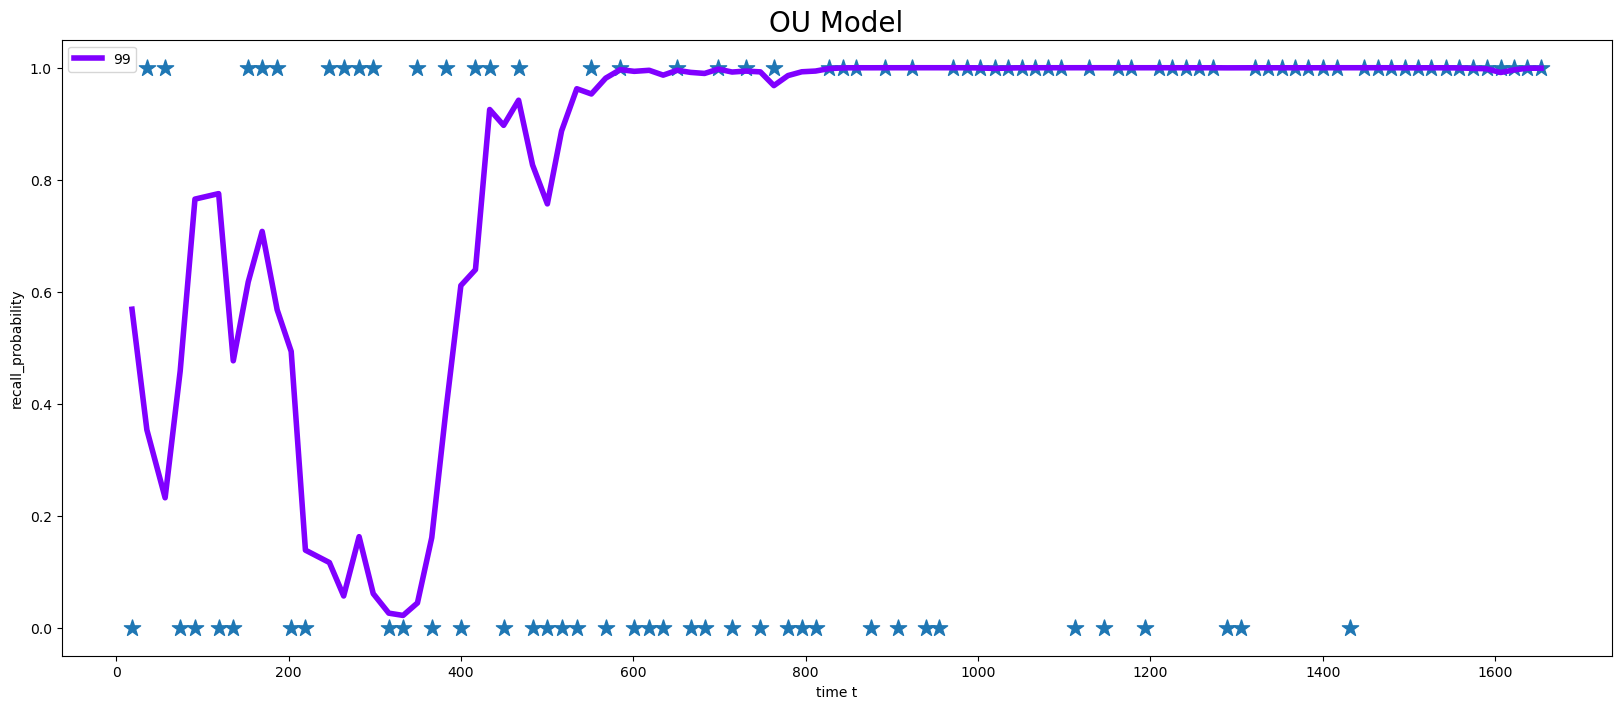

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import networkx as nx
import os
import imageio
import ipdb



path = x[0,:,0,0].numpy()
times=time[0].numpy()

plt.clf()

color = cm.rainbow(np.linspace(0, 1, num_node))
plt.figure(figsize=(20,8))
plt.xlabel('time t')
plt.ylabel('recall_probability')
plt.title(label='OU Model',
        fontsize=20,
        color="black")

plt.plot(scale, sigmoid(path), color=c, label='{}'.format(i), linewidth=4)

plt.scatter(scale, x_data[1:], s=150, marker='*')
    # plt.vlines(x=times[ind], ymin = np.min(path), ymax = np.max(path),
            # colors = 'grey', linestyles='dashdot')# ,
            # label = 'vline_multiple - full height')


plt.legend()

In [92]:
num_seq, time_step = t.shape
num_node = len(x0)

dt = torch.diff(t).reshape(num_seq, -1, 1, 1)
dt = torch.tile(dt, (1,1,num_node,1))
dt = torch.log(dt)

# x = torch.zeros((self.num_seq, time_step, num_node, 1), device=device)
# x[:, 0] += x0

noise = torch.randn(size=(num_seq, time_step, num_node, 1), device=device) 
scale = std(dt) # [bs, t-1, num_node, 1]
# x[:, 1:] += noise[:, 1:] * scale
x_last = x0

x_pred = []
for i in range(1, test_time):
    # x[:, i] = self.mean(x[:, i-1], dt[:, i-1])
    x_next = mean(x_last, dt[:, i-1]) + noise[:, i-1]
    x_last = x_next
    x_pred.append(x_next)

# Data

,user_id,exercise,count
98,16,adding_and_subtracting_negative_numbers,118
387,52,alternate_exterior_angles,119
388,52,alternate_interior_angles,101
492,52,metric_weight_unit_conversion,136
654,64,reading_fractions_in_chinese,148
...,...,...,...
2288785,247492,multiplication_0.5,741
2288786,247492,multiplication_1,266
2288888,247507,subtraction_1,113
2289046,247529,addition_1,119


# HLR model

,user_id,exercise,count
1144894,123793,writing_fractions_1,1
993027,107307,rounding_numbers,1
993028,107307,same_side_interior_angles,1
993039,107307,the_fundamental_theorem_of_arithmetic,1
993043,107307,understanding_comparing_angle,1
...,...,...,...
2009433,217320,sides_and_angles_of_simple_shapes,3035
537355,58228,sides_and_angles_of_simple_shapes,3127
486600,52504,radical_equations,3128
819423,88703,time_units_transformation_1,3297


In [76]:
bath_path = '/mnt/qb/work/mlcolab/hzhou52/kt/Duolingo/learning_traces.csv'
log = pd.read_csv(bath_path, encoding = "utf-8",low_memory=False)

In [77]:
log.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


In [78]:
users = log.groupby(['user_id', 'lexeme_id']).size().reset_index(name='count')
users.sort_values('count')

,user_id,lexeme_id,count
0,u:--N,01a14ea3963721a9d545dce1acc30f2f,1
3544992,u:hqtH,eb94d71d2ab1d501b230eee9d287fe73,1
3544993,u:hqtH,ec2421cd46a8a5886683b084aa8e2c5d,1
3544994,u:hqtH,ede6ab035e42c5f5523c73f955f036ac,1
3544995,u:hqtH,eee8e3c0843d6ace41d204202f197909,1
...,...,...,...
269756,u:bcH_,97e922f780d628eac638bea7a02bf496,278
269685,u:bcH_,827a8ecb89f9b59ac5c29b620a5d3ed6,295
269409,u:bcH_,33a7fd42f74b2d2b1110f1b0c8b6db38,316
269600,u:bcH_,6d4c572af8022cb4784ce0f8898d1905,328


In [79]:
log.loc[log.user_id == 'u:bcH_']

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
193803,0.0,1362092353,61015,u:bcH_,en,es,55f383178cf0fdc463ef1ebf91bd288d,milk/milk<n><sg>,157,116,1,0
193804,1.0,1362092353,83142,u:bcH_,en,es,a5acd980d17d726d1c99e7b974d3f52d,for/for<pr>,750,481,1,1
193805,0.0,1362092353,83951,u:bcH_,en,es,9eedd98a29691237d18c127468452836,music/music<n><sg>,181,110,1,0
193806,0.0,1362092353,61191,u:bcH_,en,es,4adf5cd40d521b02a9cc241bf3adc6bb,have/have<vblex><inf>,913,583,1,0
193807,0.0,1362092353,83951,u:bcH_,en,es,b830ca5fa936b0cff94fe712d6847f29,listen/listen<vblex><pres>,93,58,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12504242,1.0,1363066201,2678082,u:bcH_,en,es,6e7589c6b19e910e6f24f8313ab231b9,these/this<prn><tn><mf><pl>,43,33,1,1
12504243,1.0,1363066201,144,u:bcH_,en,es,32d10b7ed0bea958c60a915710434dfe,can/can<vaux><pres>,1166,899,1,1
12504244,0.0,1363066201,454,u:bcH_,en,es,46a16bfbe06339264594d523fb04bf7a,restaurant/restaurant<n><sg>,470,241,1,0
12504245,0.5,1363066201,144,u:bcH_,en,es,1e1f8d730c4ba99ad2873a7608324cf6,my/my<det><pos><sp>,5589,3230,2,1
